# Predicting prices with a single-asset regression model

## Preparing the independent and target variables

In [1]:
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_jpm, meta_data = ts.get_daily_adjusted(
    symbol='JPM', outputsize='full')
df_gs, meta_data = ts.get_daily_adjusted(
    symbol='GS', outputsize='full')

In [23]:
import numpy as np
import pandas as pd

df_x = pd.DataFrame({'GS': df_gs['5. adjusted close']})[::-1]

In [5]:
df_x.head()

,GS
date,
1999-11-01,54.6457
1999-11-02,54.9371
1999-11-03,54.1495
1999-11-04,55.2364
1999-11-05,58.0404


In [6]:
jpm_prices = df_jpm['5. adjusted close'][::-1]

In [7]:
jpm_prices.head()

date
1999-11-01    29.0688
1999-11-02    29.1140
1999-11-03    28.6791
1999-11-04    29.2636
1999-11-05    30.0046
Name: 5. adjusted close, dtype: float64

## Writing the linear regression model

In [8]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]

In [9]:
# def get_prices_since(df, date_since, lookback):
#     index = df.index.get_loc(date_since)
#     return df.iloc[index-lookback:index]

# df = df_x
# ys = jpm_prices
# start_date, end_date = '2019-01-01', '2019-12-31'
# lookback_period=20

# df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

# for date in df[start_date:end_date].index:
#     print(date)
#     # Fit the model
#     x = get_prices_since(df, date, lookback_period)
#     y = get_prices_since(ys, date, lookback_period)
#     model.fit(x, y.ravel())

#     # Predict the current period
#     x_current = df.loc[date].values
#     [y_pred] = model.predict([x_current])

#     # Store predictions
#     new_index = pd.to_datetime(date, format='%Y-%m-%d')
#     y_actual = ys.loc[date]
#     df_result.loc[new_index] = [y_actual, y_pred]

In [10]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                       end_date='2020', lookback_period=20)

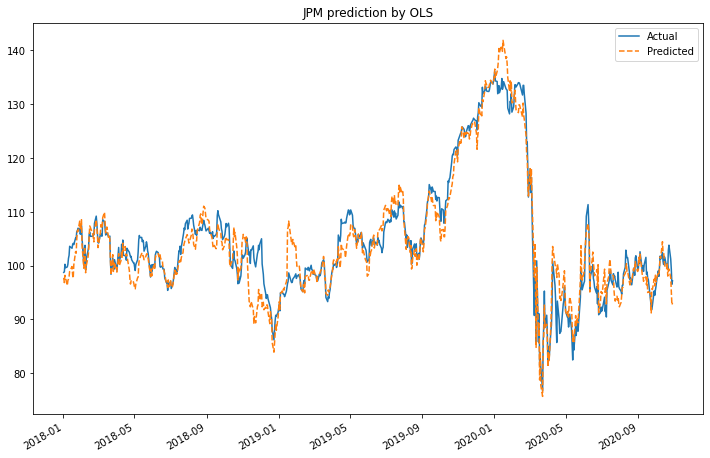

In [14]:
%matplotlib inline

linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

In [11]:
res = linear_reg_model.df_result.copy()
res.head()

,Actual,Predicted
2018-01-02,98.7502,97.740572
2018-01-03,98.8508,96.847684
2018-01-04,100.2596,98.202585
2018-01-05,99.6160,97.719692
2018-01-08,99.7631,96.302888


In [27]:
# res['Actual'].diff()

In [28]:
# (np.sign(res['Predicted'].shift(-1) - res['Actual']).shift() * res['Actual'].diff()).cumsum().plot(figsize=(12,8));

## Risk metrics for measuring prediction performance

### Mean absolute error (MAE) as a risk metric

In [15]:
from sklearn.metrics import mean_absolute_error

actual = linear_reg_model.df_result['Actual']
predicted = linear_reg_model.df_result['Predicted']

mae = mean_absolute_error(actual, predicted)
print('mean absolute error:', mae)

mean absolute error: 2.260704313949487


#### Mean squared error (MSE) as a risk metric

In [16]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predicted)
print('mean squared error:', mse)

mean squared error: 9.586525862085361


### Explained variance score as a risk metric

In [17]:
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

explained variance score: 0.9240351546112774


### R<sup>2</sup> as a risk metric

In [18]:
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted) 
print('r2 score:', r2)

r2 score: 0.9229675876185083


## Ridge regression

In [19]:
from sklearn.linear_model import Ridge

class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

In [20]:
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

In [21]:
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, 
    explained_variance_score, r2_score
)
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))    

In [22]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 1.384848194880965
mean_squared_error: 3.5887650232674404
explained_variance_score: 0.9561803521815683
r2_score: 0.9527981727971604
